In [107]:
from collections import namedtuple
from pprint import pprint

import pandas as pd
import numpy as np
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

## Text Extraction

In [2]:
# Load raw data
file_path = "./data/raw/data.xlsx"
df = pd.read_excel(file_path, engine="openpyxl", sheet_name=1)

In [3]:
df.head()

,fileName,start,end,speaker,sentiment,text,Intent,Unnamed: 7,Unnamed: 8
0,VUQC83EOO969H66VRLO5RMEPC8089Q00_2021-07-16_11...,0.81,1.27,0.0,3.0,a lô,NaN,NaN,NaN
1,NaN,1.86,2.76,0.0,3.0,anh đơn hả anh,Agent_VerifyCustomerName,NaN,NaN
2,NaN,4.62,7.86,0.0,3.0,ờ anh em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction,Agent_CompanyIntroduction,NaN
3,NaN,8.04,34.32,0.0,3.0,a lô cho em hỏi xíu ha là vợ anh chị lép á còn...,Agent_VerifyCustomerName,NaN,NaN
4,NaN,34.68,35.07,0.0,3.0,anh anh,NaN,NaN,NaN


In [4]:
# Drops some unnecessary columns
df = df.drop(columns=["fileName", "start", "end", "speaker", "sentiment"])

In [5]:
df.head()

,text,Intent,Unnamed: 7,Unnamed: 8
0,a lô,NaN,NaN,NaN
1,anh đơn hả anh,Agent_VerifyCustomerName,NaN,NaN
2,ờ anh em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction,Agent_CompanyIntroduction,NaN
3,a lô cho em hỏi xíu ha là vợ anh chị lép á còn...,Agent_VerifyCustomerName,NaN,NaN
4,anh anh,NaN,NaN,NaN


In [6]:
Dataset = namedtuple("Dataset", ["sentences", "labels"])
dataset = Dataset([], [])

for _, row in df.iterrows():
    # Avoid NaN inside text
    if isinstance(row["text"], str):
        dataset.sentences.append(row["text"])
        labels = []
        for i, val in row.iteritems():
            if i == "text" or isinstance(val, float):
                continue
            labels.append(val)
        dataset.labels.append(labels)

In [7]:
dataset.sentences[:2]

['a lô', 'anh đơn hả anh']

In [8]:
dataset.labels[:2]

[[], ['Agent_VerifyCustomerName']]

In [9]:
len(dataset.sentences), len(dataset.labels)

(8173, 8173)

## Text Cleaning

### Remove duplication

In [10]:
""" Data Cleaning
"""

# Convert to pandas dataframe from namedtuple
d = dict({
    "sentences": [],
    "labels": []
})
sentences = dataset.sentences
labels = dataset.labels
for sent, lb in zip(sentences, labels):
    # update dict
    d["sentences"].append(sent)
    d["labels"].append(lb)
for idx, item in enumerate(d["labels"]):
    if len(item) == 0:
        d["labels"][idx] = "other"
    else:
        d["labels"][idx] = " | ".join(item)

dataset_df = pd.DataFrame.from_dict(d)

# Take advantage pandas utility for text cleaning
## remove duplicate
print(f"Before drop: {len(dataset_df.index)}", end="\n\n")
dataset_df.drop_duplicates(inplace=True, ignore_index=True)
print(f"After drop: {len(dataset_df.index)}")

Before drop: 8173

After drop: 6167


In [11]:
dataset_df.head(20)

,sentences,labels
0,a lô,other
1,anh đơn hả anh,Agent_VerifyCustomerName
2,ờ anh em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction | Agent_CompanyIntrodu...
3,a lô cho em hỏi xíu ha là vợ anh chị lép á còn...,Agent_VerifyCustomerName
4,anh anh,other
5,ừm,other
6,anh đưa điện thoại giùm em,other
7,à chị lép hả chị,Agent_Self Introduction
8,à hiện tại hiện thì trong cái đợt dịch đợt dịc...,Agent_CallPurpose
9,cái điện số điện thoại cũ của chị thì em gọi n...,other


## Text Pre-processing

### Tokenization

In [12]:
for idx, row in dataset_df.iterrows():
    row["sentences"] = ViTokenizer.tokenize(row["sentences"])
dataset_df.head(10)

,sentences,labels
0,a_lô,other
1,anh đơn hả anh,Agent_VerifyCustomerName
2,ờ anh_em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction | Agent_CompanyIntrodu...
3,a_lô cho em hỏi xíu ha là vợ anh_chị lép á còn...,Agent_VerifyCustomerName
4,anh anh,other
5,ừm,other
6,anh đưa điện_thoại giùm em,other
7,à chị lép hả chị,Agent_Self Introduction
8,à hiện_tại hiện thì trong cái đợt dịch đợt dịc...,Agent_CallPurpose
9,cái điện số điện_thoại cũ của chị thì em gọi n...,other


## Modeling

In [69]:
""" We transform multi-label classification into
Multiclass classificaiton using OvR (One vs Rest) strategy
"""
X = X = dataset_df["sentences"].tolist()
y = []
items = dataset_df["labels"].tolist()
for item in items:
    labels = item.split(" | ")
    y.append(labels)

# Labels Binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [17]:
# (samples, labels)
y.shape

(6167, 38)

In [18]:
### Unique classes
mlb.classes_, len(mlb.classes_)

(array(['Agent_CallPurpose', 'Agent_ChildEducation',
        'Agent_CompanyIntroduction', 'Agent_EMI',
        'Agent_ExplainDocsRequired', 'Agent_ExplainMoneyTranferProcess',
        'Agent_FamilyShopping', 'Agent_GoodClose', 'Agent_Greetings',
        'Agent_HouseFixing', 'Agent_InformCallBack', 'Agent_InsuranceFee',
        'Agent_InterestRate', 'Agent_ListeningSkill', 'Agent_LoanAmount',
        'Agent_LoanDuration', 'Agent_MentioningDisclaimer',
        'Agent_OH_AmountLess', 'Agent_OH_BadExperience',
        'Agent_OH_CustAskForCallingBack', 'Agent_OH_DiscussWithFamily',
        'Agent_OH_HighInterest', 'Agent_OH_HighLoanDuration',
        'Agent_OH_NotRequireInsurance', 'Agent_OH_NotRequireLoan',
        'Agent_RunBusiness', 'Agent_Self Introduction', 'Agent_Summarize',
        'Agent_ThanksClosing', 'Agent_VerifyCustomerName',
        'Client_AmountLess', 'Client_AskForCallingBack',
        'Client_BadExperience', 'Client_DiscussWithFamily',
        'Client_HighInterest', 'Clie

### Feature Extraction

In [19]:
""" Text Vectorization """

# Tf-idf
tfidf_vect = TfidfVectorizer()
# tfidf_vect = tfidf_vect.fit(X)

### Model Training

In [ ]:
""" We use Grid Search for doing hyperparameters tuning """

# Cast multi-label problem to multi-class classification one.

# ## setting 1
# pipe1 = Pipeline([
#     ("vect", tfidf_vect),
#     ("clf", OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
# ])
# grid1 = [
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "clf__estimator__max_iter": [50, 100, 1000, 5000],
#         "clf__estimator__C": [0.001, 0.01, 0.1, 1., 10, 100],
#         "clf__estimator__class_weight": ["balanced", None]
#     }
# ]

## setting 2
pipe2 = Pipeline([
    ("vect", tfidf_vect),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", OneVsRestClassifier(LinearSVC(), n_jobs=-1))
])
grid2 = [
    {
        "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
        "vect__max_df": [0.2, 0.5, 0.75, 1.0],
        "vect__max_features": [500, 1000, 5000, 10000, 25000, 50000, 75000],
        "clf__estimator__C": [0.001, 0.01, 1, 10, 100],
        "clf__estimator__class_weight": ["balanced", None]
    }
]

# ## setting 3
# pipe3 = Pipeline([
#     ("vect", tfidf_vect),
#     ("clf", OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
# ])
# grid3 = [
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "clf__estimator__alpha": [0.01, 0.1, 1, 10, 100]
#     }
# ]

## Apply grid search
pipes = [pipe2]
grids = [grid2]
best_score = 0.
best_params = None
best_estimator = None
for pipe, grid in zip(pipes, grids):
    gridcv = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          scoring="f1_micro",
                          n_jobs=-1,
                          return_train_score=True)
    gridcv.fit(X, y)
    if gridcv.best_score_ > best_score:
        best_score = gridcv.best_score_
        best_params = gridcv.best_params_
        best_estimator = gridcv.best_estimator_

## Print some useful infos
print(f"best score: {gridcv.best_score_:.3f}", end="\n\n")
pprint(f"best params: {gridcv.best_params_}")


# Grid params
# grid_params = [
#     # setting 1
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "vect__min_df": [0.5, 0.75, 1.0],
#         "clf": [OneVsRestClassifier(LogisticRegression(n_jobs=-1))], # Logistic Regression
#         "clf__max_iter": [50, 100, 1000, 5000],
#         "clf__C": [0.001, 0.01, 0.1, 1., 10, 100],
#         "clf__class_weight": ["balanced", None]
#     },

#     # setting 2
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "vect__min_df": [0.5, 0.75, 1.0],
#         "clf": [OneVsRestClassifier(LinearSVC())], # SVM with linear kernel
#         "clf__C": [0.001, 0.01, 1, 10, 100],
#         "clf__class_weight": ["balanced", None]
#     },

#     # setting 3
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "vect__min_df": [0.5, 0.75, 1.0],
#         "clf": [OneVsRestClassifier(MultinomialNB())], # Multinomial Naive Bayes
#         "clf__alpha": [0.01, 0.1, 1, 10, 100]
#     }
# ]

# Apply grid search
# grid = GridSearchCV(estimator=pipe,
#                     param_grid=grid_params,
#                     scoring="f1")
# grid.fit(X, y)
# best_estimator = grid.best_estimator_
# print(f"best score: {grid.best_score_:.3f}", end="\n\n")
# pprint(f"best params: {grid.best_params_}")

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/s

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79:

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79:

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/s

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/s

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/s

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/s

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/s

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/p

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Inte

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/s

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(


In [118]:
vect = best_estimator["vect"]
print("first 10 features in the vocabulary:")
pprint([(k, v) for idx, (k, v) in enumerate(vect.vocabulary_.items())][:10])
print(f"\nNumber of features: {len(vect.get_feature_names_out())}")

first 10 features in the vocabulary:
[('anh đơn', 1993),
 ('đơn hả', 71394),
 ('hả anh', 25371),
 ('anh đơn hả', 1994),
 ('đơn hả anh', 71395),
 ('anh_em là', 2148),
 ('là hương', 31323),
 ('hương nè', 25250),
 ('nè em', 45890),
 ('em gọi', 19956)]

Number of features: 74501


In [124]:
vect.stop_words_

set()

In [87]:
pd.DataFrame.from_dict(gridcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator__C,param_clf__estimator__class_weight,param_vect__max_df,param_vect__ngram_range,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.344693,0.037110,0.046712,0.013501,0.001,balanced,0.05,"(1, 1)","{'clf__estimator__C': 0.001, 'clf__estimator__...",0.598415,...,0.630994,0.043866,147,0.710162,0.679761,0.662910,0.688450,0.666561,0.681569,0.016980
1,0.633176,0.047763,0.074988,0.008566,0.001,balanced,0.05,"(1, 2)","{'clf__estimator__C': 0.001, 'clf__estimator__...",0.703362,...,0.752298,0.049756,134,0.855713,0.834986,0.830485,0.839384,0.829102,0.837934,0.009596
2,0.578520,0.037756,0.072303,0.017235,0.001,balanced,0.05,"(2, 2)","{'clf__estimator__C': 0.001, 'clf__estimator__...",0.710466,...,0.771225,0.049501,129,0.879102,0.867488,0.855558,0.868521,0.853195,0.864773,0.009441
3,0.847042,0.161329,0.133645,0.050746,0.001,balanced,0.05,"(2, 3)","{'clf__estimator__C': 0.001, 'clf__estimator__...",0.735433,...,0.800753,0.046113,118,0.921486,0.908335,0.903238,0.913022,0.903164,0.909849,0.006873
4,0.969054,0.028667,0.129824,0.018596,0.001,balanced,0.05,"(1, 3)","{'clf__estimator__C': 0.001, 'clf__estimator__...",0.719723,...,0.774668,0.047866,128,0.901414,0.883343,0.881050,0.887715,0.881224,0.886949,0.007621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.208260,0.314146,0.128943,0.025321,100,None,0.2,"(1, 1)","{'clf__estimator__C': 100, 'clf__estimator__cl...",0.737053,...,0.797522,0.046941,119,0.979750,0.980885,0.974531,0.979251,0.974511,0.977786,0.002718
146,2.591884,0.260130,0.102821,0.033221,100,None,0.2,"(1, 2)","{'clf__estimator__C': 100, 'clf__estimator__cl...",0.773770,...,0.828016,0.043008,65,0.997314,0.998308,0.996332,0.997115,0.997419,0.997297,0.000633
147,2.084499,0.546094,0.355561,0.203146,100,None,0.2,"(2, 2)","{'clf__estimator__C': 100, 'clf__estimator__cl...",0.769483,...,0.822561,0.045277,74,0.997112,0.998209,0.996328,0.997112,0.997317,0.997216,0.000601
148,5.546057,0.130327,0.092219,0.025138,100,None,0.2,"(2, 3)","{'clf__estimator__C': 100, 'clf__estimator__cl...",0.783217,...,0.839564,0.045486,34,0.997514,0.998606,0.996531,0.997313,0.997816,0.997556,0.000676


/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label no

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 35 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label no

/home/guest/emandai/Intent-Classifier/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


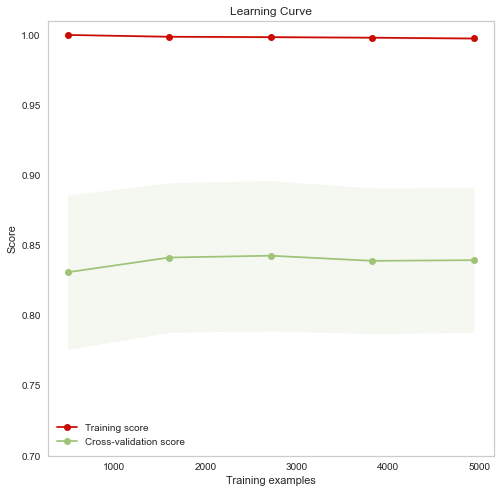

In [110]:
def plot_learning_curve(estimator, title, X, y, axe=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axe is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axe.set_title(title)

    if ylim is not None:
        axe.set_ylim(*ylim)
    axe.set_xlabel("Training examples")
    axe.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring="f1_micro",
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axe.grid()
    axe.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axe.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axe.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axe.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axe.legend(loc="best")

    return plt

_, axe = plt.subplots(1, 1, figsize=(8, 8))
plot_learning_curve(best_estimator, "Learning Curve", X, y,
                    axe=axe, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()

In [ ]:
precision_racall_viz = PrecisionRecallCurve(estimator=best_estimator,
                     per_class=True,
                     cmap="Set1")
precision_racall_viz.fit()

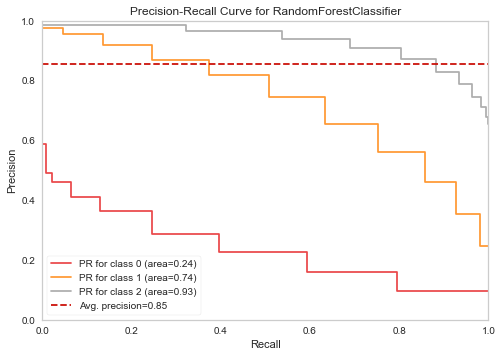

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.datasets import load_game

# Load dataset and encode categorical variables
X, y = load_game()
X = OrdinalEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, shuffle=True)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    RandomForestClassifier(n_estimators=10),
    per_class=True,
    micro=False,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()